In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

First let's prepare the data.

In [2]:
with open('spam.txt', 'r') as f:
    arr = []
    for line in f:
        row = line.split()
        row = list(map(lambda x: float(x), row))
        arr.append(row)

In [3]:
df = pd.DataFrame(arr)

In [4]:
df[57] = df[57].astype(int)

In [5]:
ds = df.to_numpy()

In [6]:
X = ds[:,:-1]

In [7]:
Y = ds[:,-1]

In [8]:
np.random.seed(42)

Below, we'll use PCA with two components to visualize the spam data. This could help us inform what kind of kernel to use for an SVM.

In [9]:
pca = PCA(n_components=2)

In [10]:
pca.fit(X)

PCA(n_components=2)

In [11]:
pca.transform(X)

array([[  -3.78689953,    9.41175717],
       [ 742.63210097,  -74.00135308],
       [2019.85407406,  102.07711051],
       ...,
       [-170.64380989,  -18.62971243],
       [-210.26925286,  -13.08443696],
       [-247.75495283,   -6.8512696 ]])

In [12]:
# The input data for spam emails
X_spam = X[Y == 1.]

In [13]:
# The input data for non-spam emails
X_not = X[Y == 0.]

In [14]:
# The two PCA components for spam emails
X_spam_trans = pca.transform(X_spam)

In [15]:
# The two PCA components for non-spam emails
X_not_trans = pca.transform(X_not)

Text(0.5, 1.0, 'PCA for spam versus non-spam emails')

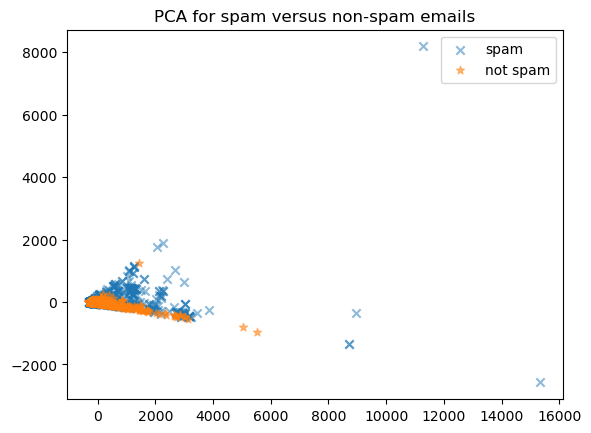

In [16]:
plt.scatter(X_spam_trans[:,0], X_spam_trans[:,1], marker='x', alpha=0.5, label='spam')
plt.scatter(X_not_trans[:,0], X_not_trans[:,1], marker='*', alpha=0.5, label='not spam')
plt.legend()
plt.title('PCA for spam versus non-spam emails')

The PCA is not all that informative as to the choice of a kernel. Below we'll carry out cross-validation to the choose the kernel.

In [17]:
def create_random_splits(X, Y, num_ch):
    """
        Split the dataset (X, Y) into num_ch random chunks
        of equal size (except for possibly the last chunk).
        (X, Y): the dataset
        num_ch: the number of chunks
    """
    
    # Randomly permute (X, Y)
    n = len(X)
    indices = np.random.permutation(n)
    X_perm = X[indices]
    Y_perm = Y[indices]
    
    k = n // num_ch
    
    # Arrays to hold the chunks
    Xs = []
    Ys = []
    
    # Append one chunk at a time
    for i in range(num_ch):
        if i < num_ch-1:
            Xs.append(X_perm[i*k:i*k + k, :])
            Ys.append(Y_perm[i*k:i*k + k])
        else:
            Xs.append(X_perm[i*k:, :])
            Ys.append(Y_perm[i*k:])
    
    return Xs, Ys

In [18]:
def get_table(Y, Y_pred):
    """
        Compute a 2x2 matrix with (i,j) entry
        equal to the number of entries with
        Y == i and Y_pred == j.
    """
    
    m00 = ((Y == 0) & (Y_pred == 0)).sum()
    m01 = ((Y == 0) & (Y_pred == 1)).sum()
    m10 = ((Y == 1) & (Y_pred == 0)).sum()
    m11 = ((Y == 1) & (Y_pred == 1)).sum()
    
    return np.array([[m00, m01],[m10, m11]])

In [19]:
def cross_validation(X, Y, num_ch, model):
    """
        Perform n-fold cross-validation where
        (X, Y): the dataset
        num_ch: the number of folds
        model: the model to fit to (X,Y)
        Returns:
            errors: a list of errors for each fold
    """
    errors = []
    Xs, Ys = create_random_splits(X, Y, num_ch)
    
    for i in range(num_ch):
        X_left_over = np.concatenate(Xs[:i] + Xs[i+1:], axis=0)
        Y_left_over = np.concatenate(Ys[:i] + Ys[i+1:], axis=0)
        X_ch = Xs[i]
        Y_ch = Ys[i]
        
        model.fit(X_left_over, Y_left_over)
        Y_pred = model.predict(X_ch)
        ((m00, m01), (m10, m11)) = get_table(Y_ch, Y_pred)
        misc = (m01 + m10) / (m00 + m01 + m10 + m11)
        errors.append(misc)

    return errors

We'll try SVM classifiers with linear, polynomial, or RBF kernel. The scikit-learn SVC class also requires a regularization parameter 'C', which adds an $L^2$ penalty. We'll try values of 'C' in $\{0.1,1.0,5,10\}$.

In [20]:
# The models to test cross-validation on
models_to_test = []

In [21]:
# Add all the models
for kernel in ['linear', 'poly', 'rbf']:
    for C in [0.01, 0.1, 1., 2.]:
        models_to_test.append(SVC(C=C, kernel=kernel))

Now we compute the cross-validation errors for each model.

In [22]:
cv_errors = []

In [23]:
for model in models_to_test:
    errors = cross_validation(X, Y, 3, model)
    cv_error = np.mean(errors)
    cv_errors.append(cv_error)
    print(f'Model: {model}, CV error: {cv_error:.4f}')

Model: SVC(C=0.01, kernel='linear'), CV error: 0.0895
Model: SVC(C=0.1, kernel='linear'), CV error: 0.0756
Model: SVC(kernel='linear'), CV error: 0.0737
Model: SVC(C=2.0, kernel='linear'), CV error: 0.0724
Model: SVC(C=0.01, kernel='poly'), CV error: 0.3577
Model: SVC(C=0.1, kernel='poly'), CV error: 0.3475
Model: SVC(kernel='poly'), CV error: 0.3436
Model: SVC(C=2.0, kernel='poly'), CV error: 0.3441
Model: SVC(C=0.01), CV error: 0.3317
Model: SVC(C=0.1), CV error: 0.3095
Model: SVC(), CV error: 0.2947
Model: SVC(C=2.0), CV error: 0.2775


In [24]:
cv_errors

[0.08954956218353656,
 0.07563321016535955,
 0.07367881277122275,
 0.07237531455995604,
 0.35774127359509533,
 0.34752902663303803,
 0.3436250480737563,
 0.34405850868302346,
 0.33166847629388346,
 0.30949484132296146,
 0.2947214838518216,
 0.277544969767539]

The lowest mean cross-validation error comes from a linear kernel with regularization parameter $C=2.0$.